In [2]:
from dotenv import load_dotenv
from IPython.display import display, HTML, Image
import os
from openai import AzureOpenAI
import json

load_dotenv()
GPT4o_API_KEY = os.getenv("GPT4o_API_KEY")
GPT4o_DEPLOYMENT_ENDPOINT = os.getenv("GPT4o_DEPLOYMENT_ENDPOINT")
GPT4o_DEPLOYMENT_NAME = os.getenv("GPT4o_DEPLOYMENT_NAME")


client = AzureOpenAI(
  azure_endpoint = GPT4o_DEPLOYMENT_ENDPOINT, 
  api_key=GPT4o_API_KEY,  
  api_version="2024-02-01"
)

In [3]:
import inspect

# helper method used to check if the correct arguments are provided to a function
def check_args(function, args):
    sig = inspect.signature(function)
    params = sig.parameters

    # Check if there are extra arguments
    for name in args:
        if name not in params:
            return False
    # Check if the required arguments are provided
    for name, param in params.items():
        if param.default is param.empty and name not in args:
            return False

    return True

In [9]:
# Defining the functions - in this case a toy example of a shipping function

def ship_to_Oceania(location):
     return f"Shipping to Oceania based on location {location}"

def ship_to_Europe(location):
    return f"Shipping to Europe based on location {location}"

def ship_to_US(location):
    return f"Shipping to Americas based on location {location}"
    

In [10]:
# Defining the available functions and their metadata to send to GPT-4-O
tools = [
    {
        "type": "function",
        "function": {
            "name": "ship_to_Oceania",
            "description": "Shipping the parcel to any country in Oceania",
            "parameters": {
                "type": "object",
                "properties": {
                    "location": {
                        "type": "string",
                        "description": "The country to ship the parcel to.",
                    }
                },
                "required": ["location"],
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "ship_to_Europe",
            "description": "Shipping the parcel to any country in Europe",
            "parameters": {
                "type": "object",
                "properties": {
                    "location": {
                        "type": "string",
                        "description": "The country to ship the parcel to.",
                    }
                },
                "required": ["location"],
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "ship_to_US",
            "description": "Shipping the parcel to any country in the United States",
            "parameters": {
                "type": "object",
                "properties": {
                    "location": {
                        "type": "string",
                        "description": "The country to ship the parcel to.",
                    }
                },
                "required": ["location"],
            },
        },
    },
]

available_functions = {
    "ship_to_Oceania": ship_to_Oceania,
    "ship_to_Europe": ship_to_Europe,
    "ship_to_US": ship_to_US,
}

In [11]:
# Encoding the functions to send to GPT-4-O
import base64

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


In [12]:
def call_OpenAI(messages, tools, available_functions):
    # Step 1: send the prompt and available functions to GPT
    response = client.chat.completions.create(
        model=GPT4o_DEPLOYMENT_NAME,
        messages=messages,
        tools=tools,
        tool_choice="auto",
    )

    response_message = response.choices[0].message

    # Step 2: check if GPT wanted to call a function
    if response_message.tool_calls:
        print("Recommended Function call:")
        print(response_message.tool_calls[0])
        print()

        # Step 3: call the function
        # Note: the JSON response may not always be valid; be sure to handle errors
        function_name = response_message.tool_calls[0].function.name

        # verify function exists
        if function_name not in available_functions:
            return "Function " + function_name + " does not exist"
        function_to_call = available_functions[function_name]

        # verify function has correct number of arguments
        function_args = json.loads(response_message.tool_calls[0].function.arguments)
        if check_args(function_to_call, function_args) is False:
            return "Invalid number of arguments for function: " + function_name
        # call the function
        function_response = function_to_call(**function_args)
        print("Output of function call:")
        print(function_response)
        print()


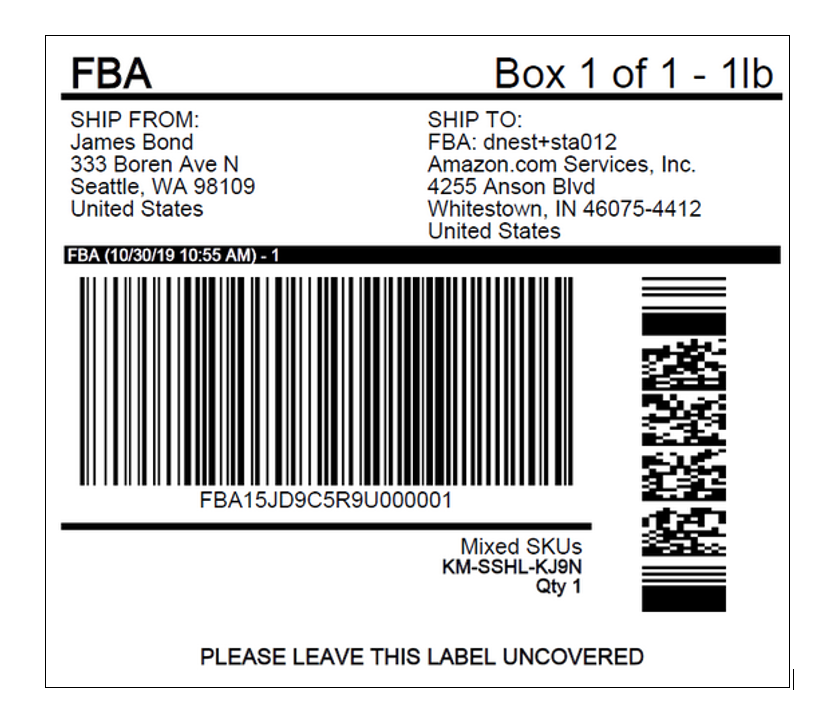

Recommended Function call:
ChatCompletionMessageToolCall(id='call_lH2G1bh2j1IfBRzZcw84wg0x', function=Function(arguments='{"location":"United States"}', name='ship_to_US'), type='function')

Output of function call:
Shipping to Americas based on location United States



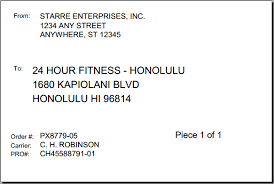

Recommended Function call:
ChatCompletionMessageToolCall(id='call_cgXSNcdfqjuZKMG0ODReulrA', function=Function(arguments='{"location":"Honolulu, HI"}', name='ship_to_US'), type='function')

Output of function call:
Shipping to Americas based on location Honolulu, HI



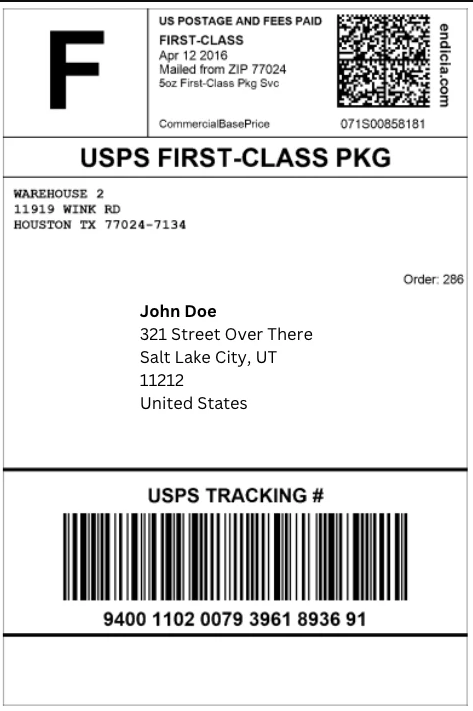

Recommended Function call:
ChatCompletionMessageToolCall(id='call_lH2G1bh2j1IfBRzZcw84wg0x', function=Function(arguments='{"location":"United States"}', name='ship_to_US'), type='function')

Output of function call:
Shipping to Americas based on location United States



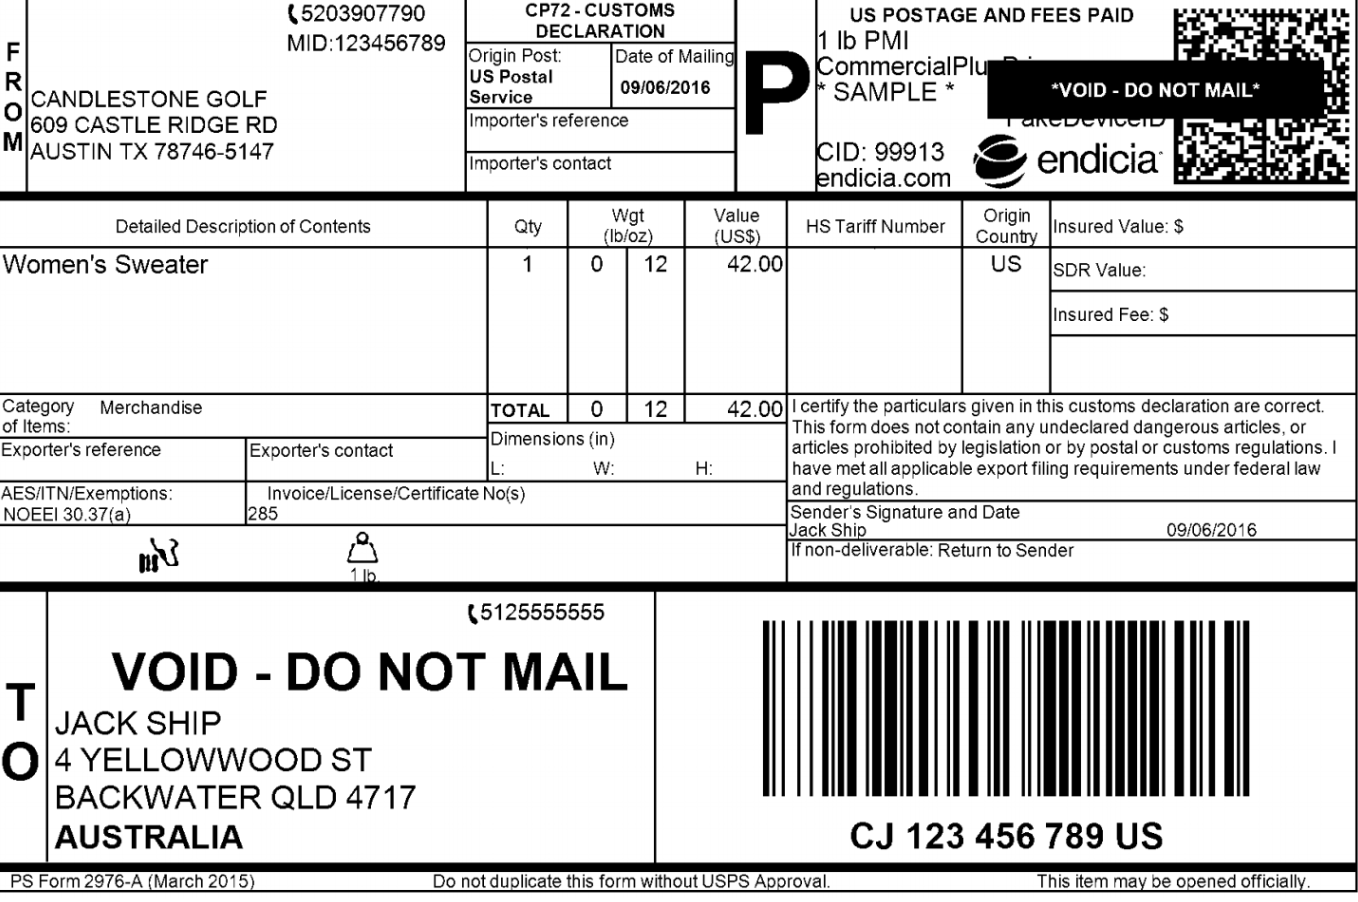

Recommended Function call:
ChatCompletionMessageToolCall(id='call_LMP2NciesoeSaCVVljDyu64D', function=Function(arguments='{"location":"Australia"}', name='ship_to_Oceania'), type='function')

Output of function call:
Shipping to Oceania based on location Australia



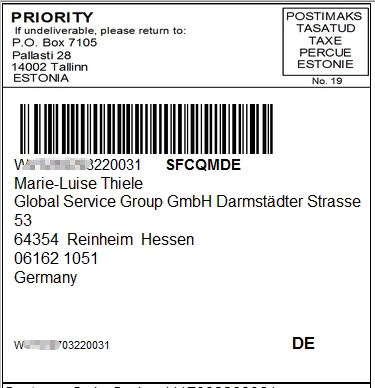

Recommended Function call:
ChatCompletionMessageToolCall(id='call_xCILvN2wTdpAzivxb47IFVQs', function=Function(arguments='{"location":"Germany"}', name='ship_to_Europe'), type='function')

Output of function call:
Shipping to Europe based on location Germany



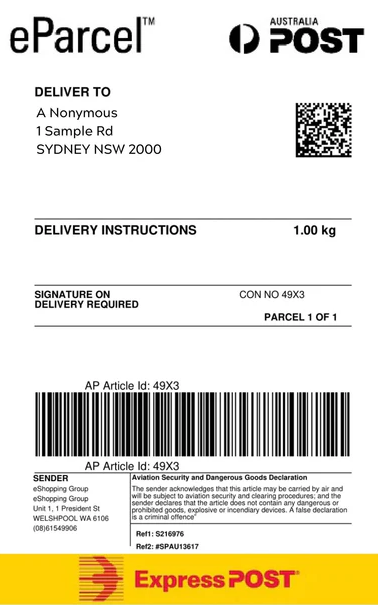

Recommended Function call:
ChatCompletionMessageToolCall(id='call_CgZtUeO885ZZaSsG7heztcQ0', function=Function(arguments='{"location":"Australia"}', name='ship_to_Oceania'), type='function')

Output of function call:
Shipping to Oceania based on location Australia



In [13]:
# iterate through all the images in the data folder
import os

data_folder = "./data"
for image in os.listdir(data_folder):
    if image.endswith(".png"):
        IMAGE_PATH = os.path.join(data_folder, image)
        base64_image = encode_image(IMAGE_PATH)
        display(Image(IMAGE_PATH))
        messages = [
            {"role": "system", "content": "You are a customer service assistant for a delivery service, equipped to analyze images of package labels. Based on the country to ship the package to, you must always ship to the corresponding continent. You must always use tools!"},
            {"role": "user", "content": [
                {"type": "image_url", "image_url": {
                    "url": f"data:image/png;base64,{base64_image}"}
                }
            ]}
        ]
        call_OpenAI(messages, tools, available_functions)